In [ ]:
!pip install shap

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/S&P')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libs

In [ ]:
import numpy as np

# Tab Data
import pandas as pd

# Geo Data
import geopandas as gpd
from shapely.geometry import shape

# Plotting
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

import plotly.express as px
import plotly.io as pio

# xgboost
import xgboost as xgb

# hyperopt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from hyperopt.early_stop import no_progress_loss

# sklearn
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [ ]:
import shap

shap.initjs()

In [ ]:
import local_functions.features as f
import local_functions.preprocessing as p

# Functinos

In [ ]:
def hyperparameter_tuning(space: dict) -> dict:
    """
    Tunes hyperparameters for an XGBoost regression model using the provided hyperparameter space.
    Evaluates the model on training and test datasets and returns the loss and model.

    Args:
        space (dict): A dictionary of hyperparameters to be used for the XGBoost model.

    Returns:
        dict: A dictionary containing the RMSE loss, status of the model, and the trained model instance.
    """
    global X_train, y_train, X_test, y_test

    model = xgb.XGBRegressor(**space)

    evaluation = [(X_train, y_train), (X_test, y_test)]

    model.fit(
        X_train,
        y_train,
        eval_set=evaluation,
        verbose=False,
    )

    pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print("SCORE:", rmse, r2)

    return {"loss": rmse, "status": STATUS_OK, "model": model}

# Data

## Geo Data

In [ ]:
geo_df = gpd.read_file("data/taxi_zones_shapefile/taxi_zones.shp")
geo_df = p.preprocess_geo_data(geo_df)
borough_map, area_map = p.get_geo_maps(geo_df)
geo_df.head()

OBJECTID  Shape_Leng  Shape_Area                         zone  \
22         23    0.290556    0.002196      Bloomfield/Emerson Hill   
131       132    0.245479    0.002038                  JFK Airport   
117       118    0.243966    0.001827  Heartland Village/Todt Hill   
43         44    0.235689    0.001945       Charleston/Tottenville   
1           2    0.433470    0.004866                  Jamaica Bay   

     LocationID        borough  \
22           23  Staten Island   
131         132         Queens   
117         118  Staten Island   
43           44  Staten Island   
1             2         Queens   

                                              geometry  area_mi2  \
22   POLYGON ((929937.155 170690.809, 929967.456 17...  7.586531   
131  MULTIPOLYGON (((1032791.001 181085.006, 103283...  7.032865   
117  POLYGON ((954167.794 161619.974, 954322.65 161...  6.630996   
43   POLYGON ((925284.273 142075.259, 924921.951 14...  5.230083   
1    MULTIPOLYGON (((1033269.244 172126.008, 103343...  5.161748   

                           centroid  
22    POINT (936800.381 160268.124)  
131  POINT (1043488.187 175062.678)  
117     POINT (947313.212 153002.2)  
43    POINT (919325.671 130813.717)  
1    POINT (1031085.719 164018.754)

## Trip Data

In [ ]:
trip_features = [
    "passenger_count",
    "trip_distance",
    "fare_amount",
    "tip_amount",
]

drop_features = ["store_and_fwd_flag"]

LOW_QUANTILE = 0.01
HIGH_QUANTILE = 0.95

us_holidays = p.get_us_holidays(2023)

In [ ]:
df = pd.read_csv(
    "data/yellow_taxi_trip_records_2023.csv",
)

<ipython-input-8-7bad0566ca6b>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [ ]:
df = (
    df.drop(columns=drop_features)
    .pipe(p.normalize_columns)
    .pipe(p.col_to_datetime)
    .pipe(p.valid_vendor_payment_filter)
    .pipe(p.valid_trip_filter, cols=trip_features)
    .pipe(p.quantile_filter, cols=trip_features, low=LOW_QUANTILE, high=HIGH_QUANTILE)
    .pipe(p.impute_missing)
    .pipe(f.calculate_time_features, us_holidays)
    .pipe(f.calculate_trip_features)
    .pipe(f.add_estimated_distance, geo_df)
    .pipe(f.add_borough, borough_map)
)

# Feature Selection

Initial assesment of features:
- **vendor_id**: Keep, vendors might have different rates
- **passenger_count**: Keep
- **pu_location_id**: Keep, starting position
- **do_location_id**: Keep, end position
- **tpep_pickup_month**: Keep
- **tpep_pickup_hour**: Keep
- **tpep_pickup_day**: Keep
- **tpep_pickup_weekday**: Keep
- **holiday**: Keep, holidays have an imact on people mobility.
- **estimated_distance**: Keep, know factor to calculate price.
- **borough**: Keep, additional location information.
- **fare_amount**: Target

# 2.1 Regression Model

## Training

In [ ]:
features = [
    "estimated_distance",
    "vendor_id",
    "passenger_count",
    "pu_location_id",
    "do_location_id",
    "tpep_pickup_month",
    "tpep_pickup_hour",
    "tpep_pickup_day",
    "tpep_pickup_weekday",
    "holiday",
    "pu_borough_Bronx",
    "pu_borough_Brooklyn",
    "pu_borough_EWR",
    "pu_borough_Manhattan",
    "pu_borough_Queens",
    "pu_borough_Staten Island",
    "pu_borough_Unknown",
    "do_borough_Bronx",
    "do_borough_Brooklyn",
    "do_borough_EWR",
    "do_borough_Manhattan",
    "do_borough_Queens",
    "do_borough_Staten Island",
    "do_borough_Unknown",
]

In [ ]:
X = df[features].to_numpy()
y = df.fare_amount.values

Splitting data for training and evaluation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=0
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Defining hyperparameter search space

In [ ]:
search_space = {
    # "booster": "dart",
    "max_depth": hp.choice("max_depth", np.arange(1, 10, 1, dtype=int)),
    "eta": hp.uniform("eta", 0, 1),
    "gamma": hp.uniform("gamma", 0, 10e1),
    "reg_alpha": hp.uniform("reg_alpha", 10e-7, 10),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "colsample_bynode": hp.uniform("colsample_bynode", 0.5, 1),
    "colsample_bylevel": hp.uniform("colsample_bylevel", 0.5, 1),
    "n_estimators": hp.choice("n_estimators", np.arange(10, 50, 1, dtype="int")),
    "min_child_weight": hp.choice("min_child_weight", np.arange(1, 10, 1, dtype="int")),
    "max_delta_step": hp.choice("max_delta_step", np.arange(1, 10, 1, dtype="int")),
    "subsample": hp.uniform("subsample", 0.5, 1),
    "objective": "reg:squarederror",  # not bat
    "eval_metric": "rmse",
    "seed": 44,
    "n_jobs": -1,
}

In [ ]:
trials = Trials()
best = fmin(
    fn=hyperparameter_tuning,
    space=search_space,
    algo=tpe.suggest,
    max_evals=3,
    trials=trials,
)

SCORE:
3.6782909555391305
0.6897081080653601
SCORE:
3.614874651188671
0.7003151741249679
SCORE:
3.5485388062952348
0.7112131678193789
100%|██████████| 3/3 [00:36<00:00, 12.27s/trial, best loss: 3.5485388062952348]


In [ ]:
# Create instace of best model.
best_model = trials.results[np.argmin([r["loss"] for r in trials.results])]["model"]

# Examine model hyperparameters
print(best_model.get_xgb_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': 0.9616094431522189, 'colsample_bynode': 0.5843148825338521, 'colsample_bytree': 0.8154840626353824, 'device': None, 'eval_metric': 'rmse', 'gamma': 38.95830599750544, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': 5, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': 9, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': 5.23472328045636, 'reg_lambda': 0.7411848520468488, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.5049240085094164, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'eta': 0.6292532861091342, 'seed': 44}


In [ ]:
evaluation = [(X_train, y_train), (X_test, y_test)]

best_model.fit(
    X_train,
    y_train,
    eval_set=evaluation,
    verbose=False,
)

pred = best_model.predict(X_test)
rmse = root_mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)
print(f"RMSE: {rmse}", f"R2: {r2}")

RMSE: 3.5485388062952348 R2: 0.7112131678193789


# 2.2 Clustering Model

We cluster the data into estimated distance groups.

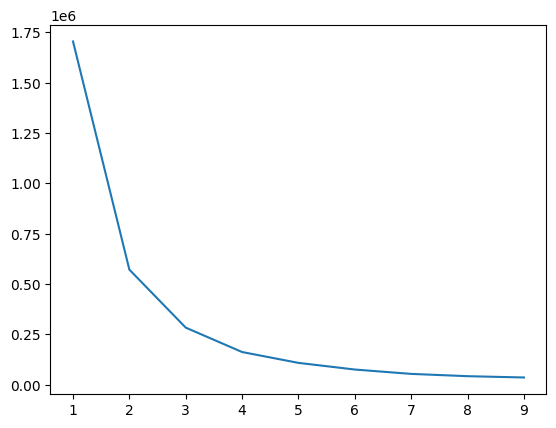

In [ ]:
WCSS = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init="k-means++")
    kmeans.fit(X_train[:, 0].reshape(-1, 1))
    WCSS.append(kmeans.inertia_)
WCSS

plt.plot(range(1, 10), WCSS)

The elbow seems to be between 2.


From this we expect the clusters to be based on the average distance of the trip, for example 'short distance' and 'long distance'


In [ ]:
kmeans = KMeans(n_clusters=2, init="k-means++")
kmeans.fit(X_train[:, 0].reshape(-1, 1))

KMeans(n_clusters=2)

# Ensemble

Adding cluster as a new feature

In [ ]:
k_train = kmeans.predict(X_train[:, 0].reshape(-1, 1))
k_test = kmeans.predict(X_test[:, 0].reshape(-1, 1))

k_train = k_train.reshape([k_train.shape[0], 1])
k_test = k_test.reshape([k_test.shape[0], 1])

X_train = np.hstack((X_train, k_train))
X_test = np.hstack((X_test, k_test))

In [ ]:
trials = Trials()
best = fmin(
    fn=hyperparameter_tuning,
    space=search_space,
    algo=tpe.suggest,
    max_evals=3,
    trials=trials,
)

SCORE:
3.150620794111687
0.7349024070107232
SCORE:
3.4857681366641105
0.7385210324498027
SCORE:
3.0103403131095738
0.787671867964478
100%|██████████| 3/3 [00:26<00:00,  8.77s/trial, best loss: 3.0103403131095738]


In [ ]:
best_ensamble = trials.results[np.argmin([r["loss"] for r in trials.results])]["model"]
print(best_ensamble.get_xgb_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': 0.8671008609327768, 'colsample_bynode': 0.6112663821295203, 'colsample_bytree': 0.9271435978483225, 'device': None, 'eval_metric': 'rmse', 'gamma': 29.832695075458904, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': 1, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 5, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': 9.127670708189376, 'reg_lambda': 0.266074206898263, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.6425371186451786, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'eta': 0.7849771308857026, 'seed': 44}


In [ ]:
evaluation = [(X_train, y_train), (X_test, y_test)]

best_ensamble.fit(
    X_train,
    y_train,
    eval_set=evaluation,
    verbose=False,
)

pred = best_ensamble.predict(X_test)
rmse = root_mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)
print(f"RMSE: {rmse}", f"R2: {r2}")

RMSE: 3.0103403131095738 R2: 0.787671867964478


We can see that using the clusters as a feature marginally increases model performance.

|                | RMSE |  R2  |
|----------------|:----:|:----:|
| Initial Model  | 3.54 | 0.71 |
| Ensamble Model | 3.01 | 0.78 |

# 3. Strategy (Shap)

In [ ]:
n_samples = 100
sample_indices = np.random.choice(X_test.shape[0], size=n_samples, replace=False)
X_sample = X_test[sample_indices, :]

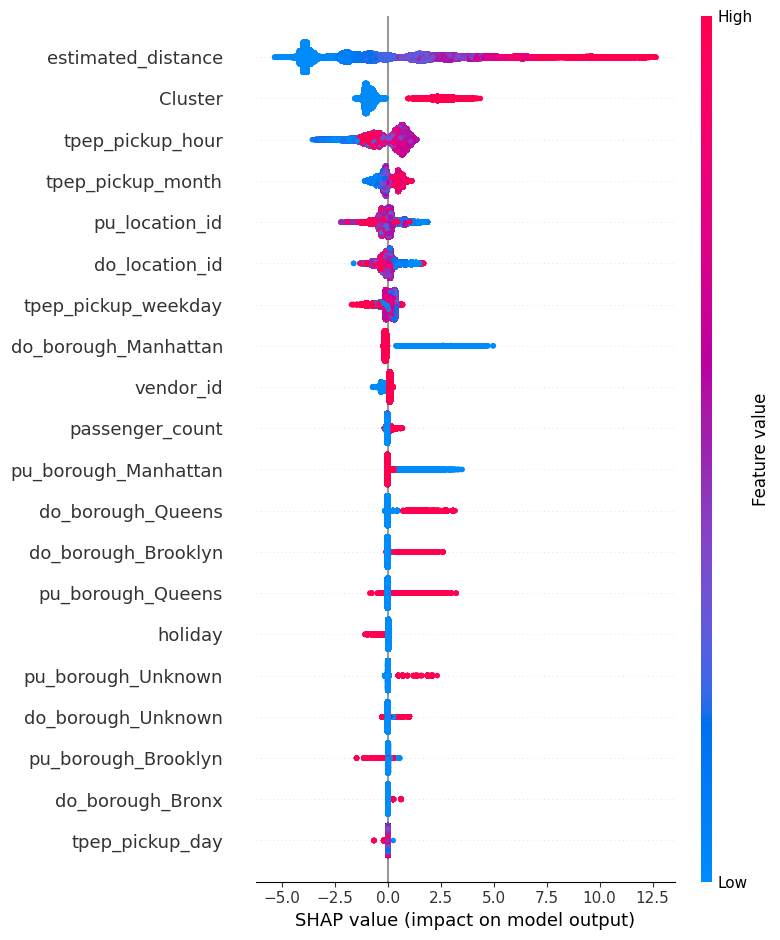

In [ ]:
features.append("Cluster")

X_test_original_features = X_test[:, : len(features)]

explainer = shap.Explainer(best_ensamble)
shap_values = explainer(X_test_original_features)
shap.summary_plot(shap_values, X_test_original_features, feature_names=features)

To optimize earnings as a taxi driver might, focus on several key strategies. First, optimize estimated distance, look for consistant long trips like in and out of airports or common housing areas for long commuters. Leverage pickup hour by being aware of peak demand times, such as morning and evening rush hours, and adjust your shift patterns accordingly, particularly on weekdays and weekends. Choose strategic pickup and destination locations by frequenting high-demand areas like business districts during weekdays and entertainment spots during evenings, while also positioning yourself near common drop-off locations such as airports and hotels.